In [45]:
import torchtext
from sklearn.model_selection import train_test_split
import tqdm
import torch
import numpy as np
from matplotlib import pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# preprocessing
data = []
with open('ustpo250k_list.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        data.append(line)

pairs = []
for item in data:
    item = item.split('>')
    src = item[0] + '>' + item[1]
    tgt = item[2]
    pair = [src, tgt]
    pairs.append(pair)

MAX_LENGTH = 48
def filterPair(p):
    return len(p[0]) < MAX_LENGTH and len(p[1]) < MAX_LENGTH  # startswith first arg must be str or a tuple of str
new_pairs = [[pair[0], pair[1]] for pair in pairs if filterPair(pair)]

train_pairs, val_pairs = train_test_split(new_pairs, test_size=0.2, random_state=1234)
tokenizer = lambda x: [char for char in x]

SRC_TEXT = torchtext.data.Field(sequential=True,
                                tokenize=tokenizer,
                                fix_length=MAX_LENGTH+2,
                                preprocessing=lambda x: ['<start>'] + x + ['<end>'])

TARG_TEXT = torchtext.data.Field(sequential=True,
                                 tokenize=tokenizer,
                                 fix_length=MAX_LENGTH+2,
                                 preprocessing=lambda x: ['start'] + x + ['end'])

def get_dataset(pairs, src, targ):
    fields = [('src', src), ('targ', targ)]
    examples = []
    for rea, pro in pairs:
        examples.append(torchtext.data.Example.fromlist([rea, pro], fields))
    return examples, fields

ds_train = torchtext.data.Dataset(*get_dataset(train_pairs, SRC_TEXT, TARG_TEXT))
ds_val = torchtext.data.Dataset(*get_dataset(val_pairs, SRC_TEXT, TARG_TEXT))

SRC_TEXT.build_vocab(ds_train)
TARG_TEXT.vocab = SRC_TEXT.vocab

ngpu = 1
BATCH_SIZE = 1536

train_iter, val_iter = torchtext.data.Iterator.splits(
    (ds_train, ds_val),
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE)
)

class DataLoader:
    def __init__(self, data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)
    
    def __len__(self):
        return self.length
    
    def __iter__(self):
        for batch in self.data_iter:
            yield (torch.transpose(batch.src, 0, 1), torch.transpose(batch.targ, 0, 1))

train_dataloader = DataLoader(train_iter)
val_dataloader = DataLoader(val_iter)

2.positional encoding

In [47]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, 2 * (i // 2) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return torch.tensor(pos_encoding, dtype=torch.float32)


cwd = os.getcwd()

def draw_pos_encoding(pos_encoding):
    plt.figure()
    plt.pcolormesh(pos_encoding[0], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.savefig(cwd + '/imgs_ustpo/pos_encoding.png')
    plt.show()




3.mask


In [48]:
pad = 1

def create_padding_mask(seq):
    seq = torch.eq(seq, torch.tensor(pad)).float() # 
    return seq[:, np.newaxis, np.newaxis, :]

def create_look_ahead_mask(size):
    mask = torch.triu(torch.ones((size, size)), diagonal=1)
    return mask


4.scaled dot product attn

In [49]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = torch.matmul(q, k.transpose(-1, -2))
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * 1e-9)
    
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)

    output = torch.matmul(attention_weights, v)

    return output, attention_weights

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)



5.multi-head attention


In [50]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = torch.nn.Linear(d_model, d_model)
        self.wk = torch.nn.Linear(d_model, d_model)
        self.wv = torch.nn.Linear(d_model, d_model)

        self.final_linear = torch.nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(1, 2)
    
    def forward(self, q, k, v, mask):
        batch_size = q.shape[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = scaled_attention.transpose(1, 2)
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)

        output = self.final_linear(concat_attention)
        return output, attention_weights

6.point wise ffn


In [51]:
def point_wise_feed_forward_network(d_model, dff):
    feed_forward_net = torch.nn.Sequential(
        torch.nn.Linear(d_model, dff),
        torch.nn.ReLU(),
        torch.nn.Linear(dff, d_model)
    )
    return feed_forward_net



7.encoder

In [52]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)

    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(attn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [53]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm3 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)
        self.dropout3 = torch.nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)

        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3, attn_weights_block1, attn_weights_block2


9.encoder

In [54]:
class Encoder(torch.nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 maximun_position_encoding,
                 rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = torch.nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=d_model)
        # print(maximun_position_encoding)
        self.pos_encoding = positional_encoding(maximun_position_encoding, d_model)

        self.enc_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)])
        self.dropout = torch.nn.Dropout(rate)

    def forward(self, x, mask):
        inp_sep_len = x.shape[-1]
        # print(x.shape)
        
        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))

        pos_encoding = self.pos_encoding[:, :inp_sep_len, :]

        pos_encoding = pos_encoding.cuda('cuda:0')
        # print(x.shape, pos_encoding.shape)
        x += pos_encoding

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
        return x


10.decoder


In [55]:
class Decoder(torch.nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 target_vocab_size,
                 maximun_position_encoding,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = torch.nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding, d_model)

        self.dec_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)])
        self.dropout = torch.nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        targ_seq_len = x.shape[-1]
        # print(targ_seq_len)
        attention_weights = {}

        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))

        pos_encoding = self.pos_encoding[:, :targ_seq_len, :]
        
        pos_encoding = pos_encoding.cuda('cuda:0')

       
        x += pos_encoding

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, attn_block1, attn_block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i + 1}_block1'] = attn_block1
            attention_weights[f'decoder_layer{i + 1}_block2'] = attn_block2
        
        return x, attention_weights

11.transformer


In [56]:
class Transformer(torch.nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 target_vocab_size,
                 pe_input,
                 pe_target,
                 rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers,
                               d_model, 
                               num_heads,
                               dff,
                               input_vocab_size,
                               pe_input,
                               rate)
        self.decoder = Decoder(num_layers,
                               d_model, 
                               num_heads,
                               dff,
                               target_vocab_size,
                               pe_target,
                               rate)
        self.final_layer = torch.nn.Linear(d_model, target_vocab_size)

    def forward(self, inp, targ, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, enc_padding_mask)

        dec_output, attention_weights = self.decoder(targ, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

12.hyper params

In [57]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(SRC_TEXT.vocab)
target_vocab_size = len(TARG_TEXT.vocab)
dropout_rate = 0.1

13. optimizer

In [58]:
class CustomSchedule(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, d_model, warm_steps=4):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warm_steps

        super(CustomSchedule, self).__init__(optimizer)

    def get_lr(self):
        arg1 = self._step_count ** (-0.5)
        arg2 = self._step_count * (self.warmup_steps ** -1.5)
        dynamic_lr = (self.d_model ** (-0.5)) * min(arg1, arg2)

        return [dynamic_lr for group in self.optimizer.param_groups]


14.loss and metrics

In [59]:
loss_object = torch.nn.CrossEntropyLoss(reduction='none')


In [60]:
def mask_loss_function(real, pred):
    _loss = loss_object(pred.transpose(-1, -2), real.to('cuda:0'))

    mask = torch.logical_not(real.eq(pad)).type(_loss.dtype)

    _loss *= mask

    return _loss.sum() / mask.sum().item()

2是batchsize 5是目标序列长度，6是目标词表大小
对于长度5的序列中每一个token其归类到具体值都有6种可能，即6分类
这里的词表ids为0-5
示例数据的范围选在0-4或者0-5但不能超过

loss的输出为（2， 5）5对应序列长度中的每个位置

In [61]:
def mask_loss_function2(real, pred):
    _loss = loss_object(pred.transpose(-1, -2), real)

    mask = torch.logical_not(real.eq(pad))
    _loss = _loss.masked_select(mask)
    
    return _loss.mean()

In [62]:
def mask_accuracy_func(real, pred):
    _pred = pred.argmax(dim=-1)
    corrects = _pred.eq(real)

    mask = torch.logical_not(real.eq(pad))

    corrects *= mask

    return corrects.sum().float() / mask.sum().item()

In [63]:
def mask_accuracy_func2(real, pred):
    _pred = pred.argmax(dim=-1)
    corrects = _pred.eq(real).type(torch.float32)

    mask = torch.logical_not(real.eq(pad))
    corrects = corrects.masked_select(mask)

    return corrects.mean()

In [64]:
def mask_accuracy_func3(real, pred):
    _pred = pred.argmax(dim=-1)
    corrects = _pred.eq(real)

    mask = torch.logical_not(real.eq(pad))
    corrects = torch.logical_and(corrects, mask)

    return corrects.sum().float() / mask.sum().item()

15.mask generate

In [65]:
def create_mask(inp, targ):
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(targ.shape[-1])

    dec_targ_padding_mask = create_padding_mask(targ)
    combined_mask = torch.max(look_ahead_mask, dec_targ_padding_mask)

    dec_padding_mask = create_padding_mask(inp)

    return enc_padding_mask, combined_mask, dec_padding_mask
    
    

16.train and save

In [66]:
save_dir = cwd + '/save/'

In [67]:
transformer = Transformer(num_layers,
                          d_model, 
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [68]:
transformer = transformer.to(device)
ngpu = 1
device_list = [5,6,7]

In [69]:
if ngpu > 1:
    transformer = torch.nn.DataParallel(transformer, device_ids=device_list)

In [70]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.01)
# lr_scheduler = CustomSchedule(optimizer, d_model, warm_steps=50)

optimizer = torch.optim.SGD(transformer.parameters(), lr=0.1)
# learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)



In [71]:
def train_step(model, inp, targ):
    targ_inp = targ[:, :-1]
    targ_real = targ[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, targ_inp)

    inp = inp.to(device)
    targ_inp = targ_inp.to(device)
    targ_real = targ_real.to(device)
    enc_padding_mask = enc_padding_mask.to(device)
    combined_mask = combined_mask.to(device)
    dec_padding_mask = dec_padding_mask.to(device)

    model.train()
    optimizer.zero_grad()

    prediction, _ = transformer(inp, targ_inp, enc_padding_mask, combined_mask, dec_padding_mask)

    loss = mask_loss_function(targ_real.to('cuda:0'), prediction.to('cuda:0'))
    metric = mask_accuracy_func(targ_real.to('cuda:0'), prediction.to('cuda:0'))

    loss.backward()
    optimizer.step()

    return loss.item(), metric.item()


In [72]:
def validate_step(model, inp, targ):
    targ_inp = targ[:, :-1]
    targ_real = targ[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, targ_inp)

    inp = inp.to(device)
    targ_inp = targ_inp.to(device)
    enc_padding_mask = enc_padding_mask.to(device)
    combined_mask = combined_mask.to(device)
    dec_padding_mask = dec_padding_mask.to(device)

    model.eval()

    with torch.no_grad():

        prediction, _ = model(inp, targ_inp, enc_padding_mask, combined_mask, dec_padding_mask)

        val_loss = mask_loss_function(targ_real.to('cuda:0'), prediction.to('cuda:0'))
        val_metric = mask_accuracy_func(targ_real.to('cuda:0'), prediction.to('cuda:0'))
    
    return val_loss.item(), val_metric.item()

In [73]:
EPOCHS = 50
print_trainstep_every = 100
metric_name = 'acc'

import pandas as pd
df_history = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_' + metric_name])
import datetime
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m_%d %H:%M:%S')
    print('\n' + "========"*8 + '%s'%nowtime)


In [74]:
import time
import copy
def train_model(model, epochs, train_dataloader, val_dataloader, print_every):
    starttime = time.time()
    print('*' * 27, 'start training...')
    printbar()

    best_acc = 0.
    for epoch in range(1, epochs + 1):

        loss_sum = 0.
        metric_sum = 0.

        for step, (inp, targ) in enumerate(train_dataloader, start=1):
            loss, metric = train_step(model, inp, targ)
            loss_sum += loss
            metric_sum += metric

            if step % print_every == 0:
                print('*' * 8, f'[step = {step}] loss: {loss_sum / step:.3f}, {metric_name}: {metric_sum / step:.3f}')
            
     
        val_loss_sum = 0.
        val_metric_sum = 0. 
        for val_step, (inp, targ) in enumerate(val_dataloader, start=1):
            loss, metric = validate_step(model, inp, targ)
            val_loss_sum += loss
            val_metric_sum += metric

        
        record = (epoch, loss_sum / step, metric_sum / step, val_loss_sum / val_step, val_metric_sum / val_step)
        df_history.loc[epoch - 1] = record

        print('EPOCH = {} loss: {:.3f}, {}: {:.3f}, val_loss: {:.3f}, val_{}: {:.3f}'.format(
            record[0], record[1], metric_name, record[2], record[3], metric_name, record[4]))
        
        printbar()

        
    checkpoint = save_dir + 'last.tar'

    if device.type == 'cuda' and ngpu > 1:
        model_sd = copy.deepcopy(model.module.state_dict())
    else:
        model_sd = copy.deepcopy(model.state_dict())
    
    torch.save({
        'loss': loss_sum / step,
        'epoch': epoch,
        'net': model_sd,
        'opt': optimizer.state_dict()
    }, checkpoint)
        
    print('finishing training...')
    endtime = time.time()
    time_elapsed = endtime - starttime
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return df_history

                

In [75]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(transformer)

1873337

In [76]:
df_history = train_model(transformer, EPOCHS, train_dataloader, val_dataloader, print_trainstep_every)


*************************** start training...

================================================================2024-01_30 19:54:12


EPOCH = 1 loss: 2.517, acc: 0.309, val_loss: 2.089, val_acc: 0.369

================================================================2024-01_30 19:54:17
EPOCH = 2 loss: 1.978, acc: 0.389, val_loss: 1.844, val_acc: 0.415

================================================================2024-01_30 19:54:23
EPOCH = 3 loss: 1.860, acc: 0.406, val_loss: 1.780, val_acc: 0.415

================================================================2024-01_30 19:54:29
EPOCH = 4 loss: 1.781, acc: 0.425, val_loss: 1.722, val_acc: 0.424

================================================================2024-01_30 19:54:35
EPOCH = 5 loss: 1.736, acc: 0.429, val_loss: 1.669, val_acc: 0.446

================================================================2024-01_30 19:54:41
EPOCH = 6 loss: 1.695, acc: 0.438, val_loss: 1.636, val_acc: 0.446

================================================================2024-01_30 19:54:47
EPOCH = 7 loss: 1.674, acc: 0.437, val_loss: 1.614, val_acc: 0.456

====================

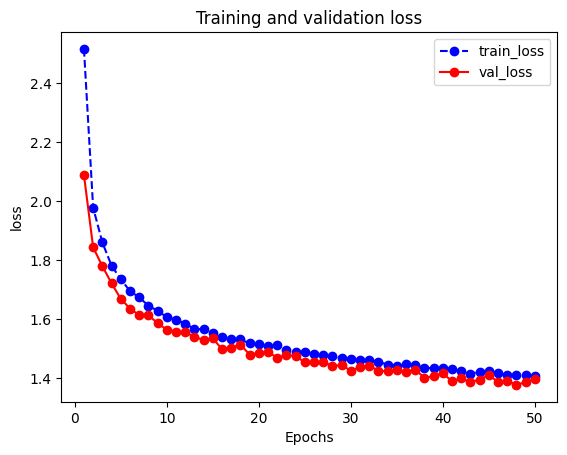

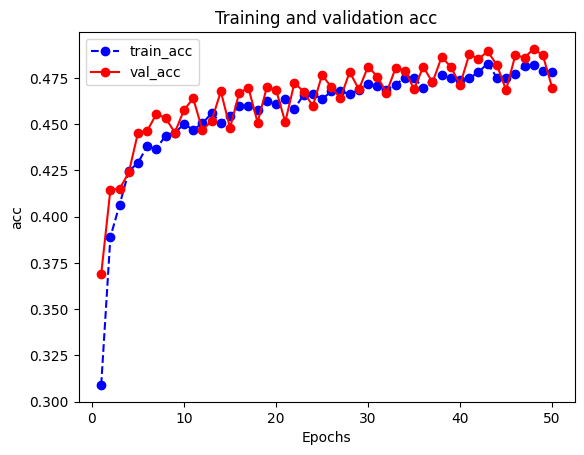

In [77]:
def plot_metric(df_history, metric):
    plt.figure()

    train_metrics = df_history[metric]
    val_metrics = df_history['val_' + metric]

    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')

    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.savefig(cwd + '/imgs/' + metric + '.png')
    plt.show()

plot_metric(df_history, 'loss')
plot_metric(df_history, metric_name)
    

In [78]:
checkpoint = save_dir + 'last.tar'
print(checkpoint)

/home/Zhouyu/MODEL/translate/save/last.tar


In [79]:
ckpt = torch.load(checkpoint)
transformer_sd = ckpt['net']

reload_model = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    input_vocab_size,
    target_vocab_size,
    pe_input=input_vocab_size,
    pe_target=target_vocab_size,
    rate=dropout_rate
)


reload_model = reload_model.to(device)

print('Loading model...')
if device.type == 'cuda' and ngpu > 1:
    reload_model.module.load_state_dict(transformer_sd)
else:
    reload_model.load_state_dict(transformer_sd)

print('Model loaded...') 

Loading model...
Model loaded...


In [80]:
def test(model, dataloader):
    test_loss_sum = 0. 
    test_metric_sum = 0.

    for test_step, (inp, targ) in enumerate(dataloader, start=1):
        loss, metric = validate_step(model, inp, targ)
        test_loss_sum += loss
        test_metric_sum += metric
    
    print('*' * 8,
          'Test: loss: {:.3f}, {}: {:.3f}'.format(test_loss_sum / test_step, 'test_acc', test_metric_sum / test_step))
    
print('*' * 8, 'final test...')
test(reload_model, val_dataloader)

******** final test...


******** Test: loss: 1.398, test_acc: 0.470


In [81]:
def tokenizer_encode(tokenize, sentence, vocab):
    sentence = tokenize(sentence)
    sentence = ['<start>'] + sentence + ['<end>']
    sentence_ids = [vocab.stoi[token] for token in sentence]
    return sentence_ids

def tokenizer_decode(sentence_ids, vocab):
    sentence = [vocab.itos[id] for id in sentence_ids if id < len(vocab)]
    return " ".join(sentence)


In [82]:
def evaluate(model, inp_sentence):
    model.eval()

    inp_sentence_ids = tokenizer_encode(tokenizer, inp_sentence, SRC_TEXT.vocab)
    encoder_input = torch.tensor(inp_sentence_ids).unsqueeze(0)
    # print(encoder_input.shape)
    decoder_input = [TARG_TEXT.vocab.stoi['<start>']]
    decoder_input = torch.tensor(decoder_input).unsqueeze(0)

    with torch.no_grad():
        for i in range(MAX_LENGTH + 1):
            # print(i)
            enc_padding_mask, combined_mask, dec_padding_mask = create_mask(encoder_input.cpu(), decoder_input.cpu())

            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            enc_padding_mask = enc_padding_mask.to(device)
            combined_mask = combined_mask.to(device)
            dec_padding_mask = dec_padding_mask.to(device)
            # print(decoder_input.shape)
            prediction, attention_weights = model(encoder_input,
                                                  decoder_input,
                                                  enc_padding_mask,
                                                  combined_mask,
                                                  dec_padding_mask)
            prediction = prediction[:, -1:, :]
            prediction_id = torch.argmax(prediction, dim=-1)
            if prediction_id.squeeze().item() == TARG_TEXT.vocab.stoi['<end>']:
                return decoder_input.squeeze(0), attention_weights
            
            decoder_input = torch.cat([decoder_input, prediction_id], dim=-1)
    return decoder_input.squeeze(0), attention_weights


In [83]:
sentence_pairs = [
    ['C#CCC(C)C.CN(c1ccc(C(O)(c2ccc(Cl)cc2)C(F)', 'CC(C)CC#CC(O)(c1ccc(N(C)S(=O)(=O)c2ccccc2)cc1)C(F)(F)F'],
    ['CN(C[C@@H]1CC[C@@H](COC/C=C/CBr)CC1)S(=O)', 'CC(=O)N(C)C>CN(C[C@@H]1CC[C@@H](COC/C=C/CN(CCO)CCO)CC1)S(=O)(=O)c1ccc(C(F)(F)F)cc1']

]

In [84]:
def batch_translate(sentence_pairs):
    for pair in sentence_pairs:
        print("input: ", pair[0])
        print("target: ", pair[1])

        pred_result, _ = evaluate(reload_model, pair[0])
        pred_sentence = tokenizer_decode(pred_result, TARG_TEXT.vocab)
        print('pred: ', pred_sentence)
        

In [85]:
batch_translate(sentence_pairs)

input:  C#CCC(C)C.CN(c1ccc(C(O)(c2ccc(Cl)cc2)C(F)
target:  CC(C)CC#CC(O)(c1ccc(N(C)S(=O)(=O)c2ccccc2)cc1)C(F)(F)F


pred:  <start> C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C
input:  CN(C[C@@H]1CC[C@@H](COC/C=C/CBr)CC1)S(=O)
target:  CC(=O)N(C)C>CN(C[C@@H]1CC[C@@H](COC/C=C/CN(CCO)CCO)CC1)S(=O)(=O)c1ccc(C(F)(F)F)cc1
pred:  <start> 1 <unk> C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C 1 C


In [86]:
def plot_attention_weights(attention, sentence, pred_sentence, layer):
    '''sentence = sentence.split()
    pred_sentence = pred_sentence.split()'''

    sentence = [char for char in sentence]
    pred_sentence = [char for char in pred_sentence]

    fig = plt.figure(figsize=(16, 16))

    attention = torch.squeeze(attention[layer], dim=0)

    for head in range(1):
        ax = fig.add_subplot(1, 1, 1)
        cax = ax.matshow(attention[head].cpu(), cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence) + 2))
        ax.set_yticks(range(len(pred_sentence)))

        ax.set_ylim(len(pred_sentence) - 1.5, -0.5)

        ax.set_xticklabels(['<start>'] + sentence + ['<end>'], fontdict=fontdict, rotation=90)
        ax.set_yticklabels(pred_sentence, fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))
    
    plt.tight_layout()
    plt.show()
    

In [87]:
def translate(sentence_pairs, plot=None):
    print('input:', sentence_pairs[0])
    print('target:', sentence_pairs[1])

    pred_result, attention_weights = evaluate(reload_model, sentence_pairs[0])
    print('attention_weights:', attention_weights.keys())
    pred_sentence = tokenizer_decode(pred_result, TARG_TEXT.vocab)
    print('pred:', pred_sentence)

    if plot:
        plot_attention_weights(attention_weights, sentence_pairs[0], pred_sentence, plot)

input: C#CCC(C)C.CN(c1ccc(C(O)(c2ccc(Cl)cc2)C(F)
target: CC(C)CC#CC(O)(c1ccc(N(C)S(=O)(=O)c2ccccc2)cc1)C(F)(F)F
attention_weights: dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2', 'decoder_layer2_block1', 'decoder_layer2_block2', 'decoder_layer3_block1', 'decoder_layer3_block2', 'decoder_layer4_block1', 'decoder_layer4_block2'])
pred: <start> C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C


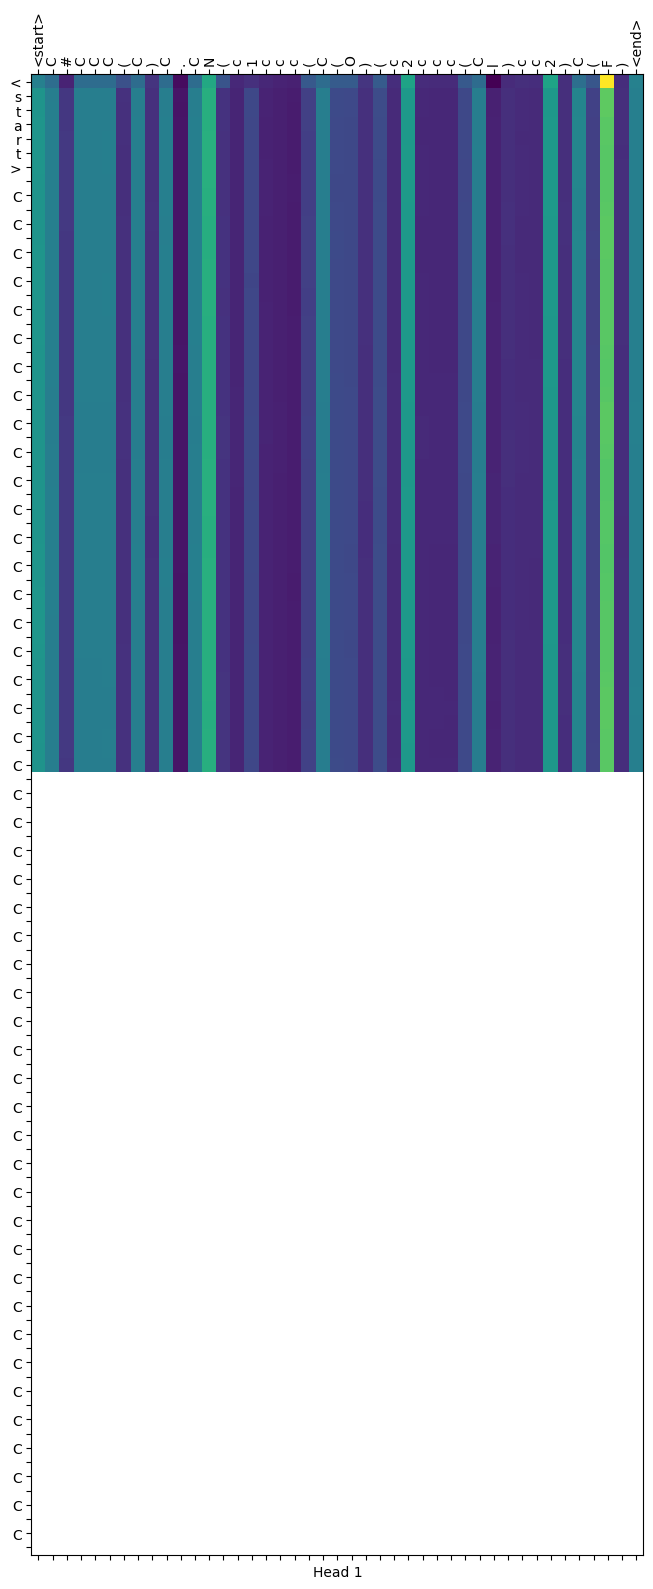

In [88]:
translate(sentence_pairs[0], plot='decoder_layer4_block2')